In [1]:
# Some standard definitions and some new:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
from astropy.time import Time
import pylab
import glob
import time
import scipy.signal
import matplotlib.cm as cm
from astropy.stats import sigma_clip
import scipy.ndimage.interpolation as interp
from scipy.ndimage.interpolation import shift
import astropy
from astropy.stats import LombScargle
from photutils import DAOStarFinder
import os
import pandas as pd
from collections import Counter
from HDI_io import construct_astrometry
import math

# photometric utilities
from photutils import DAOStarFinder,aperture_photometry, CircularAperture, CircularAnnulus

%matplotlib inline

In [2]:
direct = os.getcwd()
image = glob.glob(direct+'/Data/'+'Coord_Fu*.fit*')

datadir = direct+'/Data/'

hdulist = fits.open(image[0])

hdr_wcs = hdulist[0].header

world = construct_astrometry(hdr_wcs)

In [3]:
im_dat = fits.getdata(image[0])
bkg_sigma = 5
nsigma = 5

daofind = DAOStarFinder(fwhm=4., threshold=nsigma*bkg_sigma)

sources = daofind(im_dat)
aprad = 8

xpos = np.array(sources['xcentroid'])
ypos = np.array(sources['ycentroid'])
positions = (xpos,ypos)

taura,taudec = world.all_pix2world(xpos,ypos,0)
survey_csv = glob.glob(direct+'/Survey*.csv') #finding surveys
master_data = pd.DataFrame({'RAJ2000':taura,'DEJ2000':taudec}) #making master dataframe with RADEC
columnsTitles=["RAJ2000","DEJ2000"]
master_data=master_data.reindex(columns=columnsTitles) #getting the column titles

df = pd.DataFrame({'X_pos':xpos})
master_data = pd.concat([master_data,df],axis = 1) #mash it on the end of the final dataframe

df = pd.DataFrame({'Y_pos':ypos})
master_data = pd.concat([master_data,df],axis = 1) #mash it on the end of the final dataframe

In [4]:
color_list = ['red','blue','pink','orange','white','yellow','purple'] #colors for the DS9 list


for ind in range(0,len(survey_csv)): #for all the surveys
    survey = pd.read_csv(survey_csv[ind]) #read the survey
    null_surv = survey.isnull() 
    new_survey = 0
    cut1 = 'Survey Data - ' #getting the name of the survey from the csv title
    cut2 = '.csv'
    stuff1 = survey_csv[ind].split(cut1)
    stuff2 = stuff1[1].split(cut2)
    mag_cols = [col for col in survey.columns if 'mag' in col] #finding the columns with magnitudes
    data = np.empty((len(taura),len(mag_cols),)) #building empty array to fill with mags
    data[:] = np.nan #making the array full of nans
    file = open(stuff2[0]+'matched_sources.reg','w') #opening a survey specific reg file
    aprad = 8+ind
    
    for star in range(0,len(survey)): #for every star in the survey
        s_ra = survey['RAJ2000'][star] #ra for survey star
        s_de = survey['DEJ2000'][star] #dec for survey star
        try:
            pot_ra = np.where(np.abs(taura-s_ra)<(3e-3))[0] #find where the known stars RA is close to the surveys
            pot_de = np.where(np.abs(taudec-s_de)<(3e-3))[0] #same for DEC
            for jj in range(0,len(pot_ra)): #for every potential match in RA
                for rr in range(0,len(pot_de)): #and in DEC
                    if pot_ra[jj]==pot_de[rr]: #if the index matches for RA and DEC
                        #print(str(pot_ra[jj])+' , '+str(pot_de[rr]))
                        for mag in range(0,len(mag_cols)): #grab the mag for that star
                            data[pot_ra[jj],mag] = survey[mag_cols[mag]][star] #put it in the data array
                        file.write('circle '+str(xpos[pot_ra[jj]])+' '+str(ypos[pot_de[rr]])+' '+str(int(aprad))+' # width='+str(ind+3)+' color='+color_list[ind]+'\n')
        except: # if theres no matches skip
            pass

        
    for mag in range(0,len(mag_cols)): #for all the magnitudes in the survey
        df = pd.DataFrame({stuff2[0]+' '+mag_cols[mag]:data[:,mag]}) #make the array a dataframe
        master_data = pd.concat([master_data,df],axis = 1) #mash it on the end of the final dataframe
    file.close()

In [5]:
ref_ind = {}
ref_star_coord = pd.read_csv('reference_stars.csv')

aprad=12.  # aperture radius
skybuff=4.  # sky annulus inner radius
skywidth=8.  # sky annulus outer radius

for ind in range(0,len(ref_star_coord)):
    ref_ind[ind] = math.floor(master_data.loc[(master_data['RAJ2000']>=(ref_star_coord['RA'][ind]-1e-5)) & (master_data['RAJ2000']<=(ref_star_coord['RA'][ind]+1e-5))].index.astype(int)[0])

file = open('ref_stars_check.reg','w')
for star in range(0,len(ref_ind)):
    file.write('circle '+str(xpos[ref_ind[star]])+' '+str(ypos[ref_ind[star]])+' '+str(int(aprad))+' # width=2 color='+'red'+'text={'+str()+'}'+'\n')
    file.write('circle '+str(xpos[ref_ind[star]])+' '+str(ypos[ref_ind[star]])+' '+str(int(aprad+skybuff))+' # width=2 color='+'blue'+'\n')
    file.write('circle '+str(xpos[ref_ind[star]])+' '+str(ypos[ref_ind[star]])+' '+str(int(aprad+skybuff+skywidth))+' # width=2 color='+'blue'+'\n')
    
file.close()

In [60]:
xpos[ref_ind[ind]]

99.355132961624335

# MIKE'S PHOT CODE

In [6]:
#MIKE'S PHOT SETUP

aprad=10.  # aperture radius
skybuff=4.  # sky annulus inner radius
skywidth=8.  # sky annulus outer radius

filters = ['V','R','I']
nstars = len(xpos)

# make the master list of apertures

apertures = CircularAperture(positions, r=aprad)
annulus_apertures = CircularAnnulus(positions, r_in=aprad+skybuff, r_out=aprad+skybuff+skywidth)
apers = [apertures, annulus_apertures]

area_of_ap = apertures.area()
area_of_background = annulus_apertures.area()

# this defines a box for noise properties. 
#it's best if it's empty...but won't be too thrown by faint stars.

boxsize = 200
xboxcorner = 2500
yboxcorner = 3000

GAIN = 1.3

In [ ]:
#MIKE SAYS 'Get ready to wait...'

Photometry = {}
ePhotometry = {}
Times = {}


for filtername in filters:
    
    #need all the * for dealing with the different naming
    imglist = glob.glob(datadir+'*'+filtername+'*/*.fits')

    nimages = len(imglist) #how many images there are
    
    print('Found {} images'.format(nimages)) #telling user how many images there are
    
    # initialize the array
    Photometry[filtername] = np.zeros([nimages,nstars])
    ePhotometry[filtername] = np.zeros([nimages,nstars])
    Times[filtername] = np.zeros(nimages)



    for imgnum in range(0,nimages): #for every image
        
        print(imglist[imgnum].split('/')[-1]) #printing parts of image name as data is taken

        data_image,hdr = fits.getdata(imglist[imgnum],header=True) #getting data and header
        Times[filtername][imgnum] = hdr['MJD-OBS'] #grabbing obvs time
        
        # do the photometry!
        phot_table = aperture_photometry(data_image, apers)

        flux0 = np.array(phot_table['aperture_sum_0']) - \
        (area_of_ap/area_of_background)*np.array(phot_table['aperture_sum_1'])

        #
        if imgnum==1:
            phot_table[filtername+'_flux'] = flux0
        # stuff into a new matrix
        #
        Photometry[filtername][imgnum] = flux0
        
        #
        # error stuff
        #
        skyvar = np.std(data_image[xboxcorner:xboxcorner+boxsize,yboxcorner:yboxcorner+boxsize])**2.
    
        # want to check and make sure this is actually background (percentile check?)
    
        err1 = area_of_ap * skyvar  # scatter in sky values
    
        err2 = flux0/GAIN # Poisson error
    
        err3 = skyvar*(area_of_ap)**2./(boxsize*boxsize) # uncertainty in mean sky brightness
    
        #print ('Scatter in sky values: ',err1**0.5,', uncertainty in mean sky brightness: ',err3**0.5)
    
        errtot = (err1 + err2 + err3)**0.5
        
        #now we need error handling...
        ePhotometry[filtername][imgnum] = errtot
        
        # should likely also do cleaning here, to nan out negative values
        Photometry[filtername][imgnum][Photometry[filtername][imgnum] <= 0.] = np.nan
        

Found 37 images
c_Night3V1.fits
c_Night3V2.fits
c_Night3V3.fits
c_Night3V4.fits
c_Night3V5.fits
c_Night3V6.fits
c_Night4V1.fits
c_Night4V2.fits
c_Night4V3.fits
c_Night4V4.fits
c_Night4V5.fits
c_Night4V6.fits
c_Night4V7.fits
c_Night4V8.fits
c_Night5V1.fits
c_Night5V2.fits
c_Night6V1.fits
c_Night6V2.fits
c_Night6V3.fits
c_Night6V4.fits
c_Night2V1.fits
c_Night2V2.fits
c_Night2V3.fits
c_Night7V1.fits
c_Night7V2.fits
c_Night7V3.fits
c_Night7V4.fits
c_Night7V5.fits
c_Night7V6.fits
c_Night7V7.fits
c_Night7V8.fits
c_Night8V1.fits
c_Night8V2.fits
c_Night8V3.fits
c_Night8V4.fits
c_Night8V5.fits
c_Night8V6.fits
Found 35 images
c_Night3R2.fits
c_Night3R3.fits
c_Night3R4.fits
c_Night3R5.fits
c_Night3R6.fits
c_Night3R7.fits
c_Night3R8.fits
c_Night4R1.fits
c_Night4R2.fits
c_Night4R3.fits
c_Night4R4.fits
c_Night4R5.fits
c_Night4R6.fits
c_Night5R1.fits
c_Night5R2.fits
c_Night6R1.fits
c_Night6R2.fits
c_Night6R3.fits


/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:58: RuntimeWarning: invalid value encountered in sqrt


c_Night6R4.fits
c_Night2R2.fits
c_Night7R1.fits
c_Night2R1.fits
c_Night7R2.fits
c_Night7R3.fits
c_Night7R4.fits
c_Night7R5.fits
c_Night7R6.fits
c_Night7R7.fits
c_Night8R1.fits
c_Night8R2.fits
c_Night8R3.fits
c_Night8R4.fits
c_Night8R5.fits
c_Night8R6.fits
c_Night3R1.fits
Found 34 images
c_Night3I1.fits
c_Night3I2.fits
c_Night3I3.fits
c_Night3I4.fits
c_Night3I5.fits
c_Night3I6.fits
c_Night4I1.fits
c_Night4I2.fits


In [ ]:
#print(apertures)
#print(positions)
#print(master_data)

phot_table

In [ ]:

Inst_Mag = {}

for filtname in filters:
    nimages = len(Photometry[filtname][:,0]) #the number of images from photometry in filter
    Inst_Mag[filtname] = np.zeros_like(Photometry[filtname])
    for star in range(0,nstars):
        for img in range(0,nimages):
            Inst_Mag[filtname][img,star] = 2.5*math.log10(Photometry[filtname][img,star])
    


In [ ]:
zero_p = {}
ch_mag = ['APASS Vmag','USNOB R1mag','USNOB Imag']

for filtname in filters:
    #mag_col = [col for col in master_data.columns if 'mag' in col]
    #filt_col = [col for col in mag_col if filtername in col]
    nimages = len(Inst_Mag[filtname][:,0]) #the number of images from photometry in filter
    filt_col = [col for col in ch_mag if filtname in col]
    zero_p[filtname] = np.zeros([nimages,len(ref_ind)])
    for star in range(0,len(ref_ind)):
        for img in range(0,nimages):
            zero_p[filtname][img,star] = master_data[filt_col[0]][ref_ind[star]]-Inst_Mag[filtname][img,ref_ind[star]]


In [27]:
ref_ind

{0: 12, 1: 61, 2: 116, 3: 218, 4: 253, 5: 263, 6: 296, 7: 306, 8: 495}

In [32]:
for ind in range(0,len(ref_ind)):
    print(str(ind)+' X: '+str(master_data['RAJ2000'][ref_ind[ind]])+' Y: '+str(master_data['DEJ2000'][ref_ind[ind]])+' ZP: '+str(zero_p['V'][5,:][ind]))

0 X: 64.7402169121 Y: 28.1307753865 ZP: 1.38437165125
1 X: 64.9776221911 Y: 28.1521061049 ZP: 1.00237713542
2 X: 64.6766351077 Y: 28.1948241038 ZP: 0.406247677312
3 X: 64.9462857173 Y: 28.3326329742 ZP: 4.24937713821
4 X: 64.5236389375 Y: 28.3687920778 ZP: 3.50614703077
5 X: 64.8892067613 Y: 28.3748452586 ZP: 0.293941354494
6 X: 64.9014627604 Y: 28.4114600511 ZP: 2.159879575
7 X: 64.962914094 Y: 28.4197954359 ZP: 3.97229458691
8 X: 64.8036338224 Y: 28.5683604669 ZP: 2.05387048301


In [51]:
ref_ind = {}
ref_star_coord = pd.read_csv('reference_stars.csv')

aprad=12.  # aperture radius
skybuff=4.  # sky annulus inner radius
skywidth=8.  # sky annulus outer radius

for ind in range(0,len(ref_star_coord)):
    ref_ind[ind] = math.floor(master_data.loc[(master_data['RAJ2000']>=(ref_star_coord['RA'][ind]-1e-5)) & (master_data['RAJ2000']<=(ref_star_coord['RA'][ind]+1e-5))].index.astype(int)[0])

file = open('ref_stars_check.reg','w')
for star in range(0,len(ref_ind)):
    file.write('circle '+str(xpos[ref_ind[star]])+' '+str(ypos[ref_ind[star]])+' '+str(int(aprad))+' # width=2 color='+'red'+'text={'+str()+'}'+'\n')
    file.write('circle '+str(xpos[ref_ind[star]])+' '+str(ypos[ref_ind[star]])+' '+str(int(aprad+skybuff))+' # width=2 color='+'blue'+'\n')
    file.write('circle '+str(xpos[ref_ind[star]])+' '+str(ypos[ref_ind[star]])+' '+str(int(aprad+skybuff+skywidth))+' # width=2 color='+'blue'+'\n')
    
file.close()

RAJ2000    DEJ2000        X_pos        Y_pos  UCAC4 Vmag  UCAC4 e_Vmag  \
0    64.912204  28.118184   583.815330     1.631556         NaN           NaN   
1    64.795110  28.119544  1458.200151     1.609345         NaN           NaN   
2    64.990015  28.117371     2.776502     2.876378         NaN           NaN   
3    64.446204  28.123147  4063.492091     2.755468         NaN           NaN   
4    64.812144  28.120795  1331.148646    13.830296         NaN           NaN   
5    64.679032  28.122780  2325.158635    18.420064         NaN           NaN   
6    64.610469  28.124732  2837.222515    29.071553         NaN           NaN   
7    64.740857  28.126770  1863.973132    57.752494         NaN           NaN   
8    64.563114  28.130150  3191.245704    71.073090         NaN           NaN   
9    64.797724  28.128097  1439.569371    74.289302         NaN           NaN   
10   64.591299  28.130668  2980.874372    77.750612         NaN           NaN   
11   64.838874  28.128852  1132.449627    84.653992         NaN           NaN   
12   64.740217  28.130775  1869.155695    91.610944      14.458          10.0   
13   64.717016  28.131123  2042.389966    92.445413         NaN           NaN   
14   64.930993  28.129431   444.809370    98.805063         NaN           NaN   
15   64.781609  28.131608  1560.238145   102.498881         NaN           NaN   
16   64.875640  28.131070   858.221227   107.062948         NaN           NaN   
17   64.985633  28.130120    36.989965   110.371591         NaN           NaN   
18   64.598663  28.134999  2926.285909   115.039057         NaN           NaN   
19   64.637120  28.134740  2639.177094   116.079734         NaN           NaN   
20   64.646547  28.134934  2568.824429   118.528008         NaN           NaN   
21   64.728509  28.135597  1957.039748   131.377525         NaN           NaN   
22   64.594295  28.137649  2959.131035   137.124060         NaN           NaN   
23   64.559092  28.138429  3221.989413   140.862727         NaN           NaN   
24   64.769841  28.137031  1648.642066   147.323118         NaN           NaN   
25   64.705157  28.137829  2131.579480   148.171466         NaN           NaN   
26   64.593055  28.139268  2968.533784   150.731810         NaN           NaN   
27   64.591583  28.139270  2979.520041   150.626098         NaN           NaN   
28   64.778065  28.137753  1587.324563   154.212998         NaN           NaN   
29   64.688922  28.138881  2252.868485   155.639359         NaN           NaN   
..         ...        ...          ...          ...         ...           ...   
537  64.904961  28.587597   690.253455  3976.021949         NaN           NaN   
538  64.630315  28.590753  2732.024033  3977.257491         NaN           NaN   
539  64.703700  28.590971  2186.576355  3985.460783         NaN           NaN   
540  64.986665  28.588055    82.992115  3988.386605         NaN           NaN   
541  64.960584  28.588359   276.892020  3988.207600      13.725           6.0   
542  64.720062  28.591485  2065.009434  3991.270549         NaN           NaN   
543  64.968904  28.589164   215.140465  3995.898058         NaN           NaN   
544  64.590455  28.593400  3028.544592  3996.366741         NaN           NaN   
545  64.932515  28.591103   485.836470  4008.526812         NaN           NaN   
546  64.902211  28.591761   711.155910  4011.004159         NaN           NaN   
547  64.643045  28.594962  2637.799360  4013.980346         NaN           NaN   
548  64.991175  28.591227    49.844525  4015.730801         NaN           NaN   
549  64.910871  28.592644   646.887275  4019.362065         NaN           NaN   
550  64.922076  28.593024   563.645812  4023.725171         NaN           NaN   
551  64.950786  28.592861   350.237945  4025.312496         NaN           NaN   
552  64.993476  28.592402    32.880010  4025.928479         NaN           NaN   
553  64.993384  28.592914    33.627700  4030.255975         NaN           NaN   
554  64.904056  28.594711   697.771102

/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:18: RuntimeWarning: invalid value encountered in less
/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:4016: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


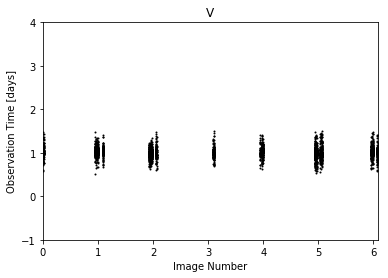

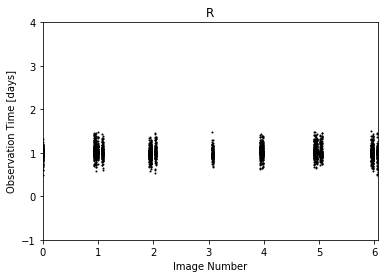

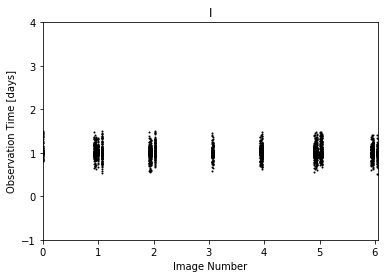

In [22]:
# detrend all stars


cPhotometry = {}

for filtername in filters: #for every filter

    nimages = len(Photometry[filtername][:,0]) #the number of images from photometry in filter
    imgindex = np.arange(0,nimages,1) #the index of the images
    cPhotometry[filtername] = np.zeros_like(Photometry[filtername]) #an array of zeros the same size as Photometry


    # get median flux value for each star (find percent change)
    for star in range(0,nstars): #for every star in the filter
        # apply an SN cut?
        SNval = Photometry[filtername][:,star]/ePhotometry[filtername][:,star] #a signal to noise cut?
        
        low_sn = np.where(SNval < 3.) #finding low signal to noise
        # blank out bad photometry
        #print(len(low_sn[0]))
        Photometry[filtername][low_sn,star] = np.nan #naning low SN
        
        # now find the median
        med_val = np.nanmedian(Photometry[filtername][:,star]) #taking the median of... each star? oh over all im
        
        if med_val <= 0.0: # known bad photometry
            cPhotometry[filtername][:,star] = Photometry[filtername][:,star]*np.nan #nan if med less than 0
        else:
            cPhotometry[filtername][:,star] = Photometry[filtername][:,star]/med_val #average the phot otherwise
            
        # do a check for outlier photometry?
        


    # remove large-scale image-to-image variation to find best stars
    for night in range(0,nimages):
        cPhotometry[filtername][night,:] = cPhotometry[filtername][night,:]/np.nanmedian(cPhotometry[filtername][night])

    # eliminate stars with outliers from consideration
    for star in range(0,nstars):
        w = np.where( (cPhotometry[filtername][:,star] < 0.5) | (cPhotometry[filtername][:,star] > 1.5))
        cPhotometry[filtername][w,star] = np.nan
        

for filtername in filters:
    
    plt.figure()
    # check how we did via plot
    for star in range(0,100):
        plt.scatter(Times[filtername]-np.nanmin(Times[filtername]),cPhotometry[filtername][:,star],s=1.,color='black')



    plt.ylim(-1.,4.)
    plt.xlim(0,np.max(Times[filtername]-np.nanmin(Times[filtername])))

    plt.ylabel('Observation Time [days]')
    plt.xlabel('Image Number')
    plt.title(filtername)

In [77]:
filtername='R'
#np.where( (star_err < accuracy_threshold) & (np.nanmedian(Photometry[filtername],axis=0) > 100.) )
#np.where( (np.nanmedian(Photometry[filtername],axis=0)< 1000.) & (np.nanmedian(Photometry[filtername],axis=0) > 100.) )
#print(np.where( (star_err < accuracy_threshold) ))
#print(np.where( (np.nanmedian(Photometry[filtername],axis=0)< 10000.) ))
np.where( (star_err < accuracy_threshold) &(np.nanmedian(Photometry[filtername],axis=0) > 100.) & (np.nanmedian(Photometry[filtername],axis=0)< 10000.))[0]

/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in less
/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:4016: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in greater


array([ 23,  63, 115, 183, 207, 232, 236, 267, 320, 332, 342, 343, 363,
       415, 433, 441, 448, 471, 489, 494, 530])

/anaconda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1427: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in less
/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in greater
/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:4016: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:21: RuntimeWarning: divide by zero encountered in log10
/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:27: RuntimeWarning: divide by zero encountered in log10
/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:28: RuntimeWarning: divide by zero encountered in log10


19 : [ 23  63 115 183 207]
[ 3.83621594  3.86345953  3.83842521  3.88608304  3.85353012  3.75336063
  3.75362979  3.21776072  3.77219976  3.71664228  3.69716178  3.95359138
  3.84625757  3.92214506  3.94076783  3.68526041  3.8239866   3.95394458
  3.74152564] [-1.67306931 -1.70197771 -1.74099065 -1.72093487 -1.63261212 -1.6061416
 -1.66540989 -2.10046768 -1.65279632 -1.68696953 -1.69816162 -1.64481029
 -1.61370168 -1.70266048 -1.80179225 -1.60729571 -1.77559184 -1.64154639
 -1.62040018]


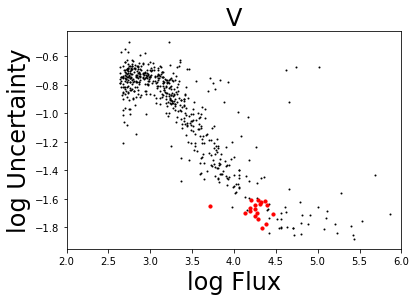

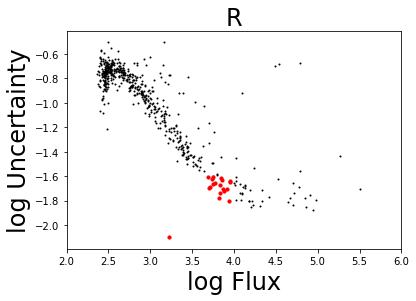

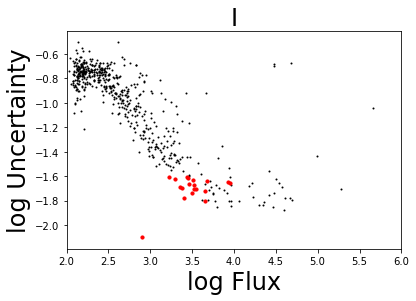

In [81]:
# select the stars with which to do the comparison

filtername='R'

star_err = np.nanstd(cPhotometry[filtername],axis=0)

accuracy_threshold = 0.025

# we may also want a flux cut?
most_accurate = np.where( (star_err < accuracy_threshold) & (star_err > 0.) & (np.nanmedian(Photometry[filtername],axis=0) < 10000.) & (np.nanmedian(Photometry[filtername],axis=0) > 100.))[0]

print(len(most_accurate),':',most_accurate[0:5])
#plt.plot(star_err[star_err.argsort()])

# select stars based on the R band similar brightness?

# choose a representative star from different magnitude bands.

plt.figure()

print(np.log10(np.nanmedian(Photometry[filtername],axis=0))[most_accurate],np.log10(star_err)[most_accurate])



for filtername in filters:
    plt.figure()
    plt.scatter(np.log10(np.nanmedian(Photometry[filtername],axis=0)),np.log10(star_err),color='black',s=1.)
    plt.scatter(np.log10(np.nanmedian(Photometry[filtername],axis=0))[most_accurate],np.log10(star_err)[most_accurate],color='red',s=10.)
    plt.xlabel('log Flux',size=24)
    plt.ylabel('log Uncertainty',size=24)
    plt.title(filtername,size=24)
    plt.xlim(2,6)

In [82]:
# calculate each star's median value


dPhotometry = {}

# carried error from photometry
edPhotometry = {}

# error on differential photometry alone
eedPhotometry = {}

# total error
tePhotometry = {}


for filtername in filters:
    print(filtername)
    


    
    nimages = len(Photometry[filtername][:,0])
    
    imgindex = np.arange(0,nimages,1)



    dPhotometry[filtername] = np.zeros_like(Photometry[filtername])
    edPhotometry[filtername] = np.zeros_like(Photometry[filtername])
    eedPhotometry[filtername] = np.zeros_like(Photometry[filtername])
    tePhotometry[filtername] = np.zeros_like(Photometry[filtername])


    for star in range(0,nstars):

        tmp_phot = np.zeros([nimages,len(most_accurate)])

        for compindex,comp in enumerate(most_accurate):
            tmp_phot[:,compindex] = (Photometry[filtername][:,star]*np.nanmedian(Photometry[filtername][:,comp]))\
                                /(Photometry[filtername][:,comp]*np.nanmedian(Photometry[filtername][:,star]))

        dPhotometry[filtername][:,star] = np.nanmedian(tmp_phot,axis=1)

        # apply final scaling factors to the photometric error
        edPhotometry[filtername][:,star] = ePhotometry[filtername][:,star]*(np.nanmedian(tmp_phot,axis=1)/Photometry[filtername][:,star])

        # the differential photometry error
        eedPhotometry[filtername][:,star] = np.nanstd(tmp_phot,axis=1)

        # the differential photometry error
        tePhotometry[filtername][:,star] = ((ePhotometry[filtername][:,star]*(np.nanmedian(tmp_phot,axis=1)/Photometry[filtername][:,star]))**2. +\
                                            (np.nanstd(tmp_phot,axis=1))**2.)**0.5




V


/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:4016: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
/anaconda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1427: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


R
I


36
1.64256756757
34
0.376016149068
34
0.375913043479


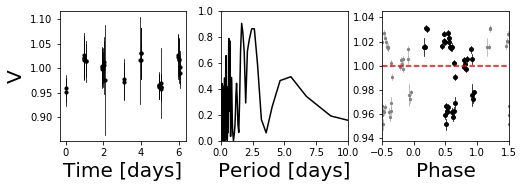

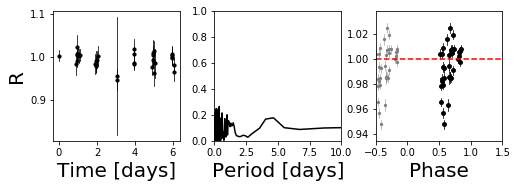

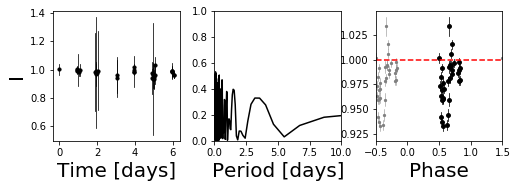

In [83]:

star = 12



for fnum,filtername in enumerate(filters):
    

    TT = Times[filtername]-np.nanmin(Times[filtername])
    DD = dPhotometry[filtername][:,star]
    ED = tePhotometry[filtername][:,star]

    w = np.where(np.isfinite(TT) & np.isfinite(DD) & np.isfinite(ED))
    
    print(len(w[0]))

    ls = LombScargle(TT[w],DD[w],ED[w])
    
    try:
        frequency, power = ls.autopower()
    except:
        print('failed in {}'.format(filtername))
        continue
        
    fig = plt.figure(fnum,figsize=(8,3))

    ax0 = fig.add_axes([0.2,0.2,0.22,0.6])
    ax1 = fig.add_axes([0.48,0.2,0.22,0.6])
    ax2 = fig.add_axes([0.76,0.2,0.22,0.6])




    nimages = len(DD)




    ax0.scatter(TT,DD,color='black',s=10.)

    for num in range(0,nimages):
        ax0.plot([TT[num],TT[num]],\
                 [DD[num]-ED[num],DD[num]+ED[num]],\
                 color='black',lw=0.75,zorder=-9)


    ax0.set_xlabel('Time [days]',size=20)
    ax1.set_xlabel('Period [days]',size=20)
    ax0.set_ylabel(filtername,size=20)
    #ax0.set_xlim(0.,3.)

    ax1.plot(1./frequency,power,color='black')
    ax1.set_xlim(0.,10.)
    ax1.set_ylim(0.,1.)
    
    w = np.where( (1./frequency > 0.2) & (1./frequency < 4.))

    best_frequency = frequency[w][np.argmax(power[w])]

    print(1./best_frequency)
    newtime = TT % (1./best_frequency)

    #print(newtime)
    newtime = newtime - np.round(newtime,0) + 0.5

           
    ax2.scatter((newtime)-1.0,DD,color='gray',s=5.)
    ax2.scatter((newtime)+1.0,DD,color='gray',s=5.)


    for num in range(0,nimages):
        ax2.plot([newtime[num]-1.,newtime[num]-1.],\
             [dPhotometry[filtername][num,star]-edPhotometry[filtername][num,star],dPhotometry[filtername][num,star]+edPhotometry[filtername][num,star]],\
             color='gray',lw=0.5,zorder=-9)
        ax2.plot([newtime[num]+1.,newtime[num]+1.],\
             [dPhotometry[filtername][num,star]-edPhotometry[filtername][num,star],dPhotometry[filtername][num,star]+edPhotometry[filtername][num,star]],\
             color='gray',lw=0.5,zorder=-9)
        ax2.plot([newtime[num],newtime[num]],\
             [dPhotometry[filtername][num,star]-edPhotometry[filtername][num,star],dPhotometry[filtername][num,star]+edPhotometry[filtername][num,star]],\
             color='black',lw=0.75,zorder=-9)




    ax2.scatter((newtime),DD,color='black',s=15.)
    


    ax2.plot([-.5,1.5],[1.,1.],color='red',linestyle='dashed')
    ax2.set_xlabel('Phase',size=20)
    #ax2.set_ylabel('Relative Photometry',size=24)
    ax2.set_xlim(-0.5,1.5)

# __TEST CODE BELOW__

In [92]:
file = open('most_accurate.reg','w') #opening a survey specific reg file
for ind in range(0,len(most_accurate)):
    file.write('circle '+str(xpos[most_accurate[ind]])+' '+str(ypos[most_accurate[ind]])+' '+str(int(aprad))+' # width=2 color=blue\n')
    
file.close()

In [87]:
ind = 0
xpos[most_accurate[ind]]

3221.9894132215322

In [95]:


survey = pd.read_csv(survey_csv[ind])
null_surv = survey.isnull()
new_survey = 0
cut1 = 'Survey Data - '
cut2 = '.csv'
stuff1 = survey_csv[ind].split(cut1)
stuff2 = stuff1[1].split(cut2)
mag_cols = [col for col in survey.columns if 'mag' in col]
data = np.empty((len(taura),len(mag_cols),))
data[:] = np.nan
len(mag_cols)
#file = open(stuff2[0]+'matched_sources.reg','w')
aprad = 8+ind
    
for star in range(0,len(survey)):
    s_ra = survey['RAJ2000'][star] #ra for survey star
    s_de = survey['DEJ2000'][star] #dec for survey star
    try:
        pot_ra = np.where(np.abs(taura-s_ra)<(3e-3))[0]
        pot_de = np.where(np.abs(taudec-s_de)<(3e-3))[0]
        for jj in range(0,len(pot_ra)):
            for rr in range(0,len(pot_de)):
                if pot_ra[jj]==pot_de[rr]:
                    #print(str(pot_ra[jj])+' , '+str(pot_de[rr]))
                    for mag in range(0,len(mag_cols)):
                        data[pot_ra[jj],mag] = survey[mag_cols[mag]][star]
                    #file.write('circle '+str(xpos[pot_ra[jj]])+' '+str(ypos[pot_de[rr]])+' '+str(int(aprad))+' # width='+str(ind+3)+' color='+color_list[ind]+'\n')
    except:
        pass

In [94]:
data = np.empty((len(taura),len(mag_cols),))
data[:] = np.nan
data[0,1] = 5
mag = 0
data[pot_ra[jj],mag] = survey[mag_cols[mag]][0]
survey[mag_cols[mag]][0]

12.694000000000001

In [29]:
new_survey = 0
for ind in range(0,len(master_data)): #for every row in master data
    null_surv = master_data.isnull() #generate a master null frame
    if null_surv[ind:ind+1].any(axis='columns')[ind]==False: #if the row has no nulls
        try:
            data = master_data[ind:ind+1] #grabbing the data at the point w/o nulls
            new_survey = new_survey.append(data,ignore_index=True) #attempting to put it into a separate survey
            print(ind)
        except AttributeError: 
            new_survey = data
            print(ind)
    
header = ["RAJ2000","DEJ2000"]
new_survey.to_csv('all_surv_stars.csv', columns = header)

12
32
61
116
184
191
218
219
253
263
296
306
320
349
495


In [31]:
master_data.

RAJ2000          64.912204
DEJ2000          28.118184
X_pos           583.815330
Y_pos             1.631556
UCAC4 Vmag             NaN
UCAC4 e_Vmag           NaN
UCAC4 rmag             NaN
UCAC4 e_rmag           NaN
UCAC4 imag             NaN
UCAC4 e_imag           NaN
USNOB R1mag      17.610000
USNOB R2mag      17.660000
USNOB Imag       16.620000
APASS Vmag             NaN
APASS e_Vmag           NaN
Name: 0, dtype: float64

In [ ]:
for star in range(0,len(survey)):
    s_ra = survey['RAJ2000'][star] #ra for survey star
    s_de = survey['DEJ2000'][star] #dec for survey star
    try:
        pot_ra = np.where(np.abs(taura-s_ra)<(3e-3))[0]
        pot_de = np.where(np.abs(taudec-s_de)<(3e-3))[0]
        for jj in range(0,len(pot_ra)):
            for rr in range(0,len(pot_de)):
                if pot_ra[jj]==pot_de[rr]:
                    print(str(pot_ra[jj])+' , '+str(pot_de[rr]))
    except:
        pass

for star in range(0,len(survey)):
        s_ra = survey['RAJ2000'][star] #ra for survey star
        s_de = survey['DEJ2000'][star] #dec for survey star
        try:
            ra_ind = np.where(np.abs(taura-s_ra)<(5e-3))[0][0] #finding the index of the ra of the star in our survey (if it's within 5arcsec)
            de_ind = np.where(np.abs(taudec-s_de)<(5e-3))[0][0] #finding the index of the dec of the star in our survey (if it's within 5arcsec)
            if ra_ind == de_ind: #if the indexes match (the coordinates are for the same star)
                if null_surv[star:star+1].any(axis='columns')[star]==False:
                    try:
                        data = survey[star:star+1]
                        new_survey = new_survey.append(data,ignore_index=True)
                    except:
                        new_survey = data
                    file.write('circle '+str(xpos[ra_ind])+' '+str(ypos[de_ind])+' '+str(int(aprad))+' # width='+str(ind+3)+' color='+color_list[ind]+'\n')
        except:
            pass
        
        
ind = 0
survey = pd.read_csv(survey_csv[1])
new_survey = 0
null_surv = survey.isnull()
if null_surv[ind:ind+1].any(axis='columns')[ind]==False:
    try:
        data = survey[ind:ind+1]
        new_survey = new_survey.append(data,ignore_index=True)
    except:
        new_survey = data
    
new_survey

#file = open(stuff2[0]+'matched_sources.reg','w')
#aprad = 8+ind
#for star in range(0,len(survey)):
#    s_ra = survey['RAJ2000'][star] #ra for survey star
#    s_de = survey['DEJ2000'][star] #dec for survey star
#    try:
#        ra_ind = np.where(np.abs(taura-s_ra)<(15e-4))[0][0] #finding the index of the ra of the star in our survey (if it's within 5arcsec)
#        de_ind = np.where(np.abs(taudec-s_de)<(15e-4))[0][0] #finding the index of the dec of the star in our survey (if it's within 5arcsec)
#        if ra_ind == de_ind: #if the indexes match (the coordinates are for the same star)
#            file.write('circle '+str(xpos[ra_ind])+' '+str(ypos[de_ind])+' '+str(int(aprad))+' # width=3 color=red\n')
#    except:
#        pass
#    
#file.close()